In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
import re
import time
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import pickle
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from fractions import Fraction

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Scraping Links

In [2]:
# ingredients from Neal
with open("ingredient_name_groups.pickle","rb") as fp:
    data = pickle.load(fp)
    
data
temp = [i[0] for i in data]

In [4]:
def nutrition_website(ingredients):
    """Use Selenium to enter the given search query into the search bar of
    nutrion website and gets links to scrape data

    Returns:
        (dictonary): urls .
    """
    #initialize variables and chrome
    ingredients_dictionary = {}
    browser = webdriver.Chrome()
    browser.get("https://www.nutritionvalue.org/")
    num_links = 3
    try:
        for i in ingredients:
            try:
                
                search_bar = browser.find_element_by_name('food_query')
                search_bar.clear()
                search_bar.send_keys(Keys.CONTROL + "a")
                search_bar.send_keys(Keys.DELETE)
                search_bar.send_keys(i)

                search_bar.send_keys(Keys.RETURN)
                
                words = i.split()
                x = ""
                for n,w in enumerate(words):
                    if n == 0:
                        x += ".*(?<!food_query=)"+w+".*|"
                    else:
                        x += ".*(?<!\+)"+w+".*|"
                x = x[:-1]
                find = re.compile(x,re.IGNORECASE)
            
                
                # wait for page to load
                time.sleep(2)
                currentURL = browser.current_url
                if "food_query" in currentURL:
                    
                    links = browser.find_elements_by_tag_name('a')
                    links = [link.get_attribute("href") for link in links if isinstance(link.get_attribute("href"),str)]
                    urls = [link for link in links if len(find.findall(link)) > 0]
                    if len(urls) >num_links:
                        ingredients_dictionary[i] = urls[:num_links]
                    elif len(urls) == 0:
                        ingredients_dictionary[i] = None
                    else:
                        ingredients_dictionary[i] = urls
                else:
                    ingredients_dictionary[i] = [currentURL]
                

            except NoSuchElementException:
                print("could not find the search bar!")
                print(i)
                return ingredients_dictionary
    # close window
    finally:
        browser.close()
    # list with all the links
    return ingredients_dictionary


In [5]:
d = nutrition_website(temp)

In [29]:
# save the links
with open("dictionary_of_links", "wb") as fp:
    pickle.dump(d,fp)


# Scraping Nutritional Values

In [ ]:
# load in the dictionary of links
with open("dictionary_of_links","rb") as fp:
    data2 = pickle.load(fp)
    

In [9]:
def nutrition_value(dictionary,set_of_links = set()):
    """Takes in a dictionary with ingredients as keys
    look through the websites and scrape the nutritional value"""
    error_items =[]
    df_d = dict()
    browser = webdriver.Chrome()
    try:
        for k,v in zip(dictionary.keys(),dictionary.values()):
            if v is None:
                df_d[k] = {}
            else:    
                for l in v:
                    try:
                        if l is None:
                            print(f"No Website for: {k}")
                            print()
                        elif l in set_of_links:
                            print(f"Duplicates for {k}")
                        else:
                            browser.get(l)
                            time.sleep(5)
                            # name of ingredient
                            name = browser.find_elements_by_tag_name('h1')[0]
                            name = name.text

                            #setting up nutritional values
                            nut = dict()
                            c = "tbody"
                            tables = browser.find_elements_by_tag_name(c)
                            #### For essentials [4]
                            ser_cal = tables[4].text.split('\n')
                            # Serving Size
                            nut[ser_cal[1][:12]] = ser_cal[1][13:]
                            #Calories
                            nut[ser_cal[3][:8]] = ser_cal[3][9:]

                            #### For all others [7-13]
                            n_v = re.compile('\s*(.*)\s([0-9]+\.[0-9]+\s\w+)')
                            for i in range(7,14):

                                nutrient_value = [n_v.findall(t) for t in tables[i].text.split('\n') if len(t) >0]
                                for t in nutrient_value:
                                    if len(t)>0:
                                        nut[t[0][0]] = t[0][1]

                            df_d[name] = nut
                            set_of_links.add(l)
                        
                    except IndexError as e:
                        error_items.append(k)
                        print(k)
                        print(l)
                        print(e)
                        print()
                    except:
                        error_items.append(k)
                        print(k)
                        print("IDK")
                        print(l)
                        print()
            
    finally:
        browser.close()
    # list with all the links
    
    
    df = pd.DataFrame.from_dict(df_d,'index')
    return df, error_items, set_of_links

    

In [ ]:
data_set,error_items,set_of_links = nutrition_value(data2)# pass in second argument if you have links that have already been scraped

In [39]:
# save unclean data
ds.to_csv("unclean_data.csv")

In [42]:
with open("Links_used_nutrition", "wb") as fp:
    pickle.dump(set_of_links,fp)


In [43]:
with open("check_these_ingredients", "wb") as fp:
    pickle.dump(error_items,fp)


# CLEAN

In [198]:
ds = pd.read_csv("unclean_data.csv",index_col = 0)

In [200]:
# floats for calories
df = ds
df["Calories"] = df['Calories'].astype('float')/100
df = df.drop(columns = ["18","Adjusted Protein"])
# changing the entries to floats and keeping track of units
clean_columns = list(df.columns)
other_units = []
g_units = []


for j,c in enumerate(clean_columns):
    if c ==  "Calories":
        
        pass
    else:    
        # float values
        n = re.compile(r"(^\d*\.?\d*)\s(\w+)")
        
        ### changing Na for 0's, to go back change 0 to np.nan
        num = np.array([float(n.findall(i)[0][0]) if isinstance(i,str) else 0 for i in df[c].values])
        mes = np.array([n.findall(i)[0][1] if isinstance(i,str) else 'g' for i in df[c].values])

        # messurements
        mask_mg = (mes == 'mg')/10
        mask_mcg = (mes == "mcg")/10000
        mask_g = (mes == "g")*.01
        mask = mask_mg + mask_mcg +mask_g
        

        mask += (mask==0)*-1

        if sum(mask < 0) >1 :
            df[c] = num/100
            other_units.append(c)

        else:
            df[c] = num*mask
            g_units.append(c)

# append new features
df.rename(columns = {c:c+ " (g)" for c in g_units if c!= "Calories"},inplace = True)
df.rename(columns = {c:c+ " (IU)" for c in other_units}, inplace = True)
df.head()

,Alanine (g),"Alcohol, ethyl (g)",Arginine (g),Ash (g),Aspartic acid (g),Beta-sitosterol (g),Betaine (g),Butanoic acid (g),Caffeine (g),"Calcium, Ca (g)",...,Vitamin B12 (g),Vitamin B6 (g),Vitamin C (g),Vitamin D (IU),Vitamin D2 (ergocalciferol) (g),Vitamin D3 (cholecalciferol) (g),Vitamin E (g),Vitamin K (g),Water (g),"Zinc, Zn (g)"
"APPLEBEE'S, Double Crunch Shrimp",0.00622,0.000,0.00894,0.0271,0.01075,0.0,0.0,0.0,0.0,4.5,...,0.000043,0.0055,0.0,0.0,0.0,0.0,0.197,0.00291,0.4012,0.078
"ARCHWAY Home Style Cookies, Date Filled Oatmeal",0.00000,0.000,0.00000,0.0162,0.00000,0.0,0.0,0.0,0.0,2.8,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000,0.00000,0.1349,0.000
"Alcoholic beverage, light, beer",0.00010,0.031,0.00000,0.0009,0.00013,0.0,0.0,0.0,0.0,0.4,...,0.000002,0.0034,0.0,0.0,0.0,0.0,0.000,0.00000,0.9488,0.001
"Alcoholic beverage, white, table, wine",0.00000,0.103,0.00000,0.0020,0.00000,0.0,0.0,0.0,0.0,0.9,...,0.000000,0.0050,0.0,0.0,0.0,0.0,0.000,0.00004,0.8686,0.012
"Apples, with skin, fuji, raw",0.00000,0.000,0.00000,0.0024,0.00000,0.0,0.0,0.0,0.0,0.7,...,0.000000,0.0045,0.0,0.0,0.0,0.0,0.018,0.00010,0.8416,0.004


In [ ]:
df = df.drop(index= ["APPLEBEE'S, Double Crunch Shrimp",'Crackers, water biscuits',"KELLOGG'S, Brown Sugar Cinnamon Roll, Wafflers, EGGO",'Cinnamon buns, frosted (includes honey buns)'])

In [66]:
df.to_csv("clean_data.csv")

# Conversion

In [16]:
df = pd.read_csv("clean_data.csv",index_col= 0 )

In [17]:
df

,Alanine (g),"Alcohol, ethyl (g)",Arginine (g),Ash (g),Aspartic acid (g),Beta-sitosterol (g),Betaine (g),Butanoic acid (g),Caffeine (g),"Calcium, Ca (g)",...,Vitamin B12 (g),Vitamin B6 (g),Vitamin C (g),Vitamin D (IU),Vitamin D2 (ergocalciferol) (g),Vitamin D3 (cholecalciferol) (g),Vitamin E (g),Vitamin K (g),Water (g),"Zinc, Zn (g)"
"APPLEBEE'S, Double Crunch Shrimp",0.622,0.0,0.894,2.71,1.075,0.000,0.0000,0.000,0.000,0.045,...,4.300000e-07,0.000055,0.0000,0.0,0.0,0.000000e+00,0.00197,2.910000e-05,40.12,0.00078
"ARCHWAY Home Style Cookies, Date Filled Oatmeal",0.000,0.0,0.000,1.62,0.000,0.000,0.0000,0.000,0.000,0.028,...,0.000000e+00,0.000000,0.0000,0.0,0.0,0.000000e+00,0.00000,0.000000e+00,13.49,0.00000
"Alcoholic beverage, light, beer",0.010,3.1,0.000,0.09,0.013,0.000,0.0000,0.000,0.000,0.004,...,2.000000e-08,0.000034,0.0000,0.0,0.0,0.000000e+00,0.00000,0.000000e+00,94.88,0.00001
"Alcoholic beverage, white, table, wine",0.000,10.3,0.000,0.20,0.000,0.000,0.0000,0.000,0.000,0.009,...,0.000000e+00,0.000050,0.0000,0.0,0.0,0.000000e+00,0.00000,4.000000e-07,86.86,0.00012
"Apples, with skin, fuji, raw",0.000,0.0,0.000,0.24,0.000,0.000,0.0000,0.000,0.000,0.007,...,0.000000e+00,0.000045,0.0000,0.0,0.0,0.000000e+00,0.00018,1.000000e-06,84.16,0.00004
"Apples, with skin, raw",0.011,0.0,0.006,0.00,0.070,0.000,0.0001,0.000,0.000,0.006,...,0.000000e+00,0.000041,0.0046,0.0,0.0,0.000000e+00,0.00018,2.200000e-06,0.00,0.00004
"Apples, without skin, raw",0.012,0.0,0.006,0.00,0.074,0.000,0.0000,0.000,0.000,0.005,...,0.000000e+00,0.000037,0.0040,0.0,0.0,0.000000e+00,0.00005,6.000000e-07,0.00,0.00005
"Asparagus, drained solids, canned",0.101,0.0,0.100,0.77,0.248,0.000,0.0007,0.000,0.000,0.016,...,0.000000e+00,0.000110,0.0184,0.0,0.0,0.000000e+00,0.00122,4.130000e-05,93.98,0.00040
"Asparagus, raw",0.115,0.0,0.091,0.58,0.508,0.000,0.0006,0.000,0.000,0.024,...,0.000000e+00,0.000091,0.0056,0.0,0.0,0.000000e+00,0.00113,4.160000e-05,93.22,0.00054
"Asparagus, unprepared, frozen",0.152,0.0,0.151,0.62,0.374,0.000,0.0000,0.000,0.000,0.025,...,0.000000e+00,0.000111,0.0318,0.0,0.0,0.000000e+00,0.00000,0.000000e+00,91.82,0.00059


In [26]:
df.rename(columns = {c:c[:-5] for c in df.columns if c[-5:] == " (IU)"},inplace = True)
df.rename(columns = {c:c[:-4] for c in df.columns if c[-4:] == " (g)"},inplace = True)

vitamins=['Choline','Niacin','Pantothenic acid','Riboflavin',
    'Thiamin','Vitamin A','Vitamin B12','Vitamin B6',
    'Vitamin C','Vitamin D','Vitamin E','Vitamin K']

minerals = ['Calcium, Ca','Copper, Cu','Iron, Fe',
    'Magnesium, Mg','Manganese, Mn','Phosphorus, P','Potassium, K',
    'Selenium, Se','Sodium, Na','Zinc, Zn']


df['Vitamins'] = df[vitamins].sum(axis=1)
df['Minerals'] = df[minerals].sum(axis=1)

Text(0.5,0.98,'Corralation between Protein, Minerals, and Vitamins')

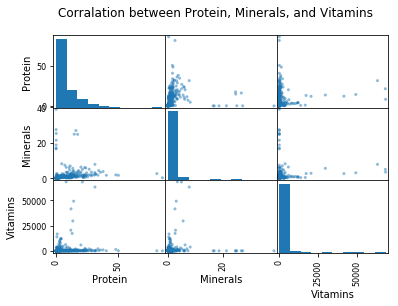

In [28]:
pd.plotting.scatter_matrix(df[['Protein','Minerals','Vitamins']])
plt.suptitle("Corralation between Protein, Minerals, and Vitamins")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d805e0a20>,
      dtype=object)

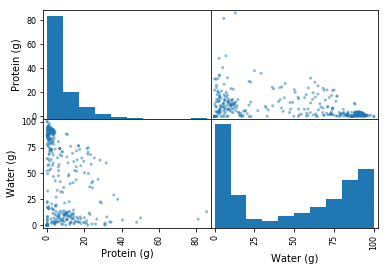

In [8]:
pd.plotting.scatter_matrix(df[['Protein (g)','Water (g)']])

In [3]:
with open("unit_dictionary", "rb") as fp:
    u = pickle.load(fp)


In [6]:
conv = {c:[] for c in set(u.values())}

In [7]:
# g/ units
conv['gram'] = 1
conv['liter'] = 1000
conv["gallon"] = 0.00026417205
conv['lbs'] = 453.592
conv['milliliter'] = 1
conv['oz']= 28.34
conv['kilogram'] = 1000
conv['tablespoon'] = 14.3
conv['teaspoon'] = 4.77
conv["cup"] = 201
conv["ear"] = 92
conv['clove'] = 7
conv['pinch'] = 0.36
conv['quart'] = 946.353
conv['pint'] = 473.176
conv['envelope'] = 7.085
conv['None'] = 0
conv['dash'] = 0.72
conv['head'] = 539
conv['stick'] = 113
conv['package'] = 7.085
conv['small'] = 75
conv['medium'] = 150
conv['large'] = 225
conv['stalk'] = 50
conv['strip'] = 10
conv['square'] = 13
conv['square'] = 56.7
conv['box'] = 382.59
conv['whole'] = 100
conv['bag'] = 453.59
conv['sprig'] = 30
conv['bulb'] = 30
conv['slice'] = 5
conv['bunch'] = 120
conv['part'] = 1
conv['cube'] = 57

# Sorted Data Frame

In [2]:
with open("sorted_dataframe.pickle","rb") as fp:
    neal_df = pickle.load(fp)
# neal_df['Other'] = [len(i) for i in neal_df['Other']]

ModuleNotFoundError: No module named 'pandas.core.internals.managers'; 'pandas.core.internals' is not a package

In [424]:
col = list(neal_df.columns) 
mask_unit = np.array([i for i in col if i[:5] == "unit_"])

'unit_sugar'

In [ ]:
# convert units to similar units
skip_if = set(u.values())
for i,v in enumerate(mask_unit):
    for j,c in enumerate(neal_df[v]):
        if c not in skip_if:
            neal_df[v][j] = u[c]
        
# neal_df 

In [15]:
# save cleaned data set
with open("sorted_dataframe2.pickle", "wb") as fp:
    pickle.dump(neal_df,fp)


In [10]:
with open("sorted_dataframe2.pickle","rb") as fp:
    neal_df = pickle.load(fp)

ModuleNotFoundError: No module named 'pandas.core.internals.managers'; 'pandas.core.internals' is not a package

In [13]:
neal_df.head()

,category,title,serving size,ingredients batch,Other,class_sugar,unit_sugar,quant_sugar,comment_sugar,ingredient_sugar,...,class_beef broth,unit_beef broth,quant_beef broth,comment_beef broth,ingredient_beef broth,class_chive,unit_chive,quant_chive,comment_chive,ingredient_chive
0,Alcoholic Beverages,Almond Liqueur,1,"[[3, cup, sugar, None, sugar], [2 1/4, cup, wa...",3,sugar,cup,3,None,sugar,...,None,None,None,None,None,None,None,None,None,None
1,Alcoholic Beverages,Cafe Mexicano,8,"[[8, cups, water, None, water; cold], [1/3, cu...",6,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Alcoholic Beverages,Coffee Liqueur,1,"[[3, cup, sugar, None, sugar], [3, cup, water,...",2,sugar,cup,3,None,sugar,...,None,None,None,None,None,None,None,None,None,None
3,Alcoholic Beverages,Chartreuse Cocktail,1,"[[1 1/2, ounces, __OTHER__, None, tequila; 3 T...",3,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Alcoholic Beverages,Whiskey Sour,1,"[[1, None, lemon juice, None, lemon; juiced], ...",1,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# changing units by hand
# u = dict()
# for i,rec in enumerate(neal_df[mask].values):
#     for j,mes in enumerate(rec):
#         if mes in u:
#             pass
#         else:
#             print(neal_df[mask].columns[j])
#             print(mes)
#             u[mes] = input()
#             print()

In [302]:
# # save dictionary with unit cleaning
# with open("unit_dictionary", "wb") as fp:
#     pickle.dump(u,fp)


In [9]:
# gets mask for ingredients (CHECK MASK BEING USED)
col = list(neal_df.columns) 
mask_class = np.array([i for i in col if i[:6] == "class_"])

In [10]:

hefty_columns = [nut_element+"_"+category[6:] for category in mask_class for nut_element in df.columns]
hefty_columns += ["Total "+ nut_element for nut_element in df.columns]

In [12]:
def st_to_fl(s):
    try:
        if s is None:
            return 1
        return float(s)
    except ValueError:
        return float(sum(Fraction(c) for c in s.split()))

In [399]:
# # want: for rpie in neal_df.index:
# #            check which classes are nonempty in rpie
# #            look at corresponding unit and quantity values
# #            use fuzzy to find the top ingredient match in df -> call it match
# #            use unit and quant values to scale values in match
# #            append scaled nutritional values into new_df
# #            for each rpie, also create total nutritional data columns

# for recipe in neal_df.index[:10]:
#     r = neal_df.iloc[recipe]
#     r_contents = r[mask_class]values != None
#     ingredients = r[mask_class][r_contents].values
#     conversion = []
#     most_similar_ings = []
#     for ing in ingredients:
#         quantity = st_to_fl(r['quant_' + ing])
#         unit_factor = conv[r['unit_' + ing]]
#         conversion.append(quantity*unit_factor)  

#         most_similar_ings.append(process.extractOne(ing,df.index)[0])
#     print(most_similar_ings)
#     df

['Popcorn, fat-free, sugar syrup/caramel', 'Water, generic, bottled', 'Beverages, fortified with vitamin D2 and E, shelf-stable, unsweetened, chocolate almond milk', 'Vanilla extract']
['Water, generic, bottled', 'Vanilla extract', 'Asparagus, drained solids, canned']
['Popcorn, fat-free, sugar syrup/caramel', 'Water, generic, bottled', 'Vanilla extract']
['Rice bran, crude']
['Lemon juice, raw', 'Sugars, powdered']
['Popcorn, fat-free, sugar syrup/caramel', 'Water, generic, bottled', 'Orange Pineapple Juice Blend', 'Orange juice, raw']
['Popcorn, fat-free, sugar syrup/caramel', 'Water, generic, bottled', 'Asparagus, drained solids, canned']
['Rice bran, crude']
['Asparagus, drained solids, canned', 'Orange Pineapple Juice Blend', 'Honey']
['Water, generic, bottled', 'Lemon juice, raw', 'Orange Pineapple Juice Blend', 'Honey', 'Lime juice, raw', 'Bread, cinnamon']


In [13]:
hefty_df = pd.DataFrame(columns=hefty_columns)
num_recipies = len(list(neal_df.index))
for num, recipe in enumerate(neal_df.index):
    r = neal_df.iloc[recipe]
    r_contents = r[mask_class].values != None
    ingredients = r[mask_class][r_contents].values
    hefty_df.loc[len(hefty_df)] = 0
    if num% 200 == 0:
        print(f"{num/num_recipies}%")
    for ing in ingredients:
        quantity = st_to_fl(r['quant_' + ing])
        unit_factor = conv[r['unit_' + ing]]
        conversion = quantity*unit_factor  
#         print(conversion)
        most_similar_ing = process.extractOne(ing,df.index)[0]
#         print(ing)
        col = list(hefty_df.columns) 
        hefty_mask = np.array([i for i in col if i[-(len(ing)+1):] == "_"+ing])
        for m,i,c in zip(hefty_mask, df.loc[most_similar_ing].values,df.columns):
            value = i*conversion
            hefty_df.loc[num][m] = value
            hefty_df.loc[num]["Total " + c] += value


0.0%
0.035977693829825505%
0.07195538765965101%
0.10793308148947653%
0.14391077531930202%
0.17988846914912754%
0.21586616297895306%
0.2518438568087786%
0.28782155063860404%
0.32379924446842956%
0.3597769382982551%
0.3957546321280806%
0.4317323259579061%
0.4677100197877316%
0.5036877136175572%
0.5396654074473827%
0.5756431012772081%
0.6116207951070336%
0.6475984889368591%
0.6835761827666846%
0.7195538765965102%
0.7555315704263357%
0.7915092642561612%
0.8274869580859867%
0.8634646519158122%
0.8994423457456378%
0.9354200395754632%
0.9713977334052887%


In [17]:
# save cleaned data set
hefty_df.to_csv("hefty_df.csv")


In [16]:
hefty_df

,Alanine (g)_sugar,"Alcohol, ethyl (g)_sugar",Arginine (g)_sugar,Ash (g)_sugar,Aspartic acid (g)_sugar,Beta-sitosterol (g)_sugar,Betaine (g)_sugar,Butanoic acid (g)_sugar,Caffeine (g)_sugar,"Calcium, Ca (g)_sugar",...,Total Vitamin B12 (g),Total Vitamin B6 (g),Total Vitamin C (g),Total Vitamin D (IU),Total Vitamin D2 (ergocalciferol) (g),Total Vitamin D3 (cholecalciferol) (g),Total Vitamin E (g),Total Vitamin K (g),Total Water (g),"Total Zinc, Zn (g)"
0,0,0,0,325.62,0,0,0,0,0,10.854,...,0,0.0482703,0,1801.8,4.29e-05,0,0.389294,0.00135675,14205.5,0.673971
1,0,0,0,0,0,0,0,0,0,0,...,0,0.0715795,0.9246,0,0,0,0.527625,0.00496973,22661.3,1.06582
2,0,0,0,325.62,0,0,0,0,0,10.854,...,0,0.0534358,0,0,0,0,0.25326,0.0016281,11002.9,0.767383
3,0,0,0,0,0,0,0,0,0,0,...,0,0.204518,0,0,0,0,0.24723,9.5475e-05,308.032,0.30351
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.54855,2.385e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5554,0,0,0,0,0,0,0,0,0,0,...,0,0.0456,0.69,0,0,0,0,0,27183,0.078
5555,0,0,0,0,0,0,0,0,0,0,...,2.86e-07,2.86e-05,0.0435262,0,0,0,0.08008,0.00024596,530.968,0.000286
5556,0,0,0,0,0,0,0,0,0,0,...,0.00137565,0.356938,5.73465,9648,0,0.0002412,1.57592,0.0425814,89657.1,2.27885
5557,0,0,0,0,0,0,0,0,0,0,...,1.12e-06,0.0760332,1.61237,126,0,0,0.017525,0.0004331,45902.2,0.139893


In [85]:
neal_df.loc[10]["ingredients batch"]

[['1', None, '__OTHER__', None, 'lime; cut into halves'],
 [None, None, 'granulated sugar', None, 'granulated sugar'],
 ['3', 'cups', '__OTHER__', None, 'cracked ice'],
 ['1/4', 'cup', 'powdered sugar', None, 'powdered sugar'],
 ['1', 'cup', '__OTHER__', None, 'tequila'],
 ['6', 'ounces', 'orange juice', None, 'frozen orange juice']]

In [72]:
hefty_mask

array(['Alanine (g)_brandy', 'Alcohol, ethyl (g)_brandy',
       'Arginine (g)_brandy', 'Ash (g)_brandy',
       'Aspartic acid (g)_brandy', 'Beta-sitosterol (g)_brandy',
       'Betaine (g)_brandy', 'Butanoic acid (g)_brandy',
       'Caffeine (g)_brandy', 'Calcium, Ca (g)_brandy',
       'Calories (g)_brandy', 'Campesterol (g)_brandy',
       'Carbohydrate (g)_brandy', 'Carotene, alpha (g)_brandy',
       'Carotene, beta (g)_brandy', 'Cholesterol (g)_brandy',
       'Choline (g)_brandy',
       'Cis,cis,cis-octadecatrienoic n-3 acid (g)_brandy',
       'Cis,cis,cis-octadecatrienoic n-6 acid (g)_brandy',
       'Cis,cis-eicosadienoic n-6 acid (g)_brandy',
       'Cis,cis-octadecadienoic n-6 acid (g)_brandy',
       'Cis-hexadecenoic acid (g)_brandy',
       'Cis-octadecenoic acid (g)_brandy', 'Copper, Cu (g)_brandy',
       'Cryptoxanthin, beta (g)_brandy', 'Cystine (g)_brandy',
       'Decanoic acid (g)_brandy', 'Dihydrophylloquinone (g)_brandy',
       'Docosahexaenoic n-3 acid (g)_

In [73]:
df.columns

Index(['Alanine (g)', 'Alcohol, ethyl (g)', 'Arginine (g)', 'Ash (g)',
       'Aspartic acid (g)', 'Beta-sitosterol (g)', 'Betaine (g)',
       'Butanoic acid (g)', 'Caffeine (g)', 'Calcium, Ca (g)',
       ...
       'Vitamin B12 (g)', 'Vitamin B6 (g)', 'Vitamin C (g)', 'Vitamin D (IU)',
       'Vitamin D2 (ergocalciferol) (g)', 'Vitamin D3 (cholecalciferol) (g)',
       'Vitamin E (g)', 'Vitamin K (g)', 'Water (g)', 'Zinc, Zn (g)'],
      dtype='object', length=142)

In [3]:

big_df = pd.read_csv("hefty_df.csv")